# IWTC Raw Source Indexing

This notebook executes the raw source indexing workflow defined in:

- `docs/raw_source_indexing_design.md`

It is intended for hands-on execution and experimentation. Conceptual scope, responsibilities, and workflow design are defined in the linked design document.

This notebook operates on a single world repository.

A minimal example of `world_repository.yml` is provided in this repository
under:

- `data/config_examples/world_repository.yml`

You may copy and adapt that example for your own world repository.

## Phase 0: Parameters

This notebook operates on a **campaign world repository** and produces draft, machine-generated indexes for human review.

In this phase, you tell the notebook **which world it is operating on** and **how broad this run should be**.

At a high level:
- You point the notebook at a world descriptor file that explains how your world’s files are organized.
- You can optionally restrict this run to specific files or folders if you are working on a subset of material.
- You choose whether to review discovered files interactively or process everything automatically.

You do **not** need to understand internal data structures or file parsing to set these parameters.  
The goal is simply to answer: *“What world am I indexing, and how much of it do I want to work on right now?”*

The code cell below contains inline comments explaining each parameter in concrete terms.


In [1]:
# Phase 0: Parameters

# Absolute path to the world_repository.yml descriptor.
WORLD_REPOSITORY_DESCRIPTOR = (
    "/Users/charissophia/obsidian/Iron Wolf Trading Company/_meta/descriptors/world_repository.yml"
)

# Optional override: use these paths instead of descriptor sources for this run.
# Examples:
#   OVERRIDE_PATHS = "/Users/you/path/to/file_or_dir"
#   OVERRIDE_PATHS = ["/Users/you/path/a", "/Users/you/path/b"]
OVERRIDE_PATHS = None

# Selection behavior:
#   "PROMPT" -> list candidates and prompt for selection
#   "ALL"    -> select all candidates
SOURCE_MODE = "PROMPT"

# Internal run metadata (do not edit)
from datetime import datetime
print(f"Notebook run initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Notebook run initialized at: 2026-01-16 14:20


## Phase 1: Load and validate world descriptor

Before this notebook can safely read or write anything, it must be confident that it understands the **structure of the world repository**.

In this phase, the notebook:

- Loads the world repository descriptor file you provided
- Confirms that it is readable and structurally valid
- Extracts only the information this notebook needs
- Verifies that referenced paths actually exist and are usable

This phase answers a single question:

**“Can I trust this descriptor enough to proceed?”**

If the answer is *no*, the notebook will stop with clear, actionable error messages explaining what needs to be fixed in the descriptor file.  
Nothing is modified, created, or scanned until this check succeeds.

This phase does **not** interpret world lore, indexing rules, or heuristics.  
It only establishes that the filesystem layout described by the world is coherent and usable.

In [2]:
# Phase 1a: Load and parse world repository descriptor

from pathlib import Path
import yaml

# Locate descriptor file
descriptor_path = Path(WORLD_REPOSITORY_DESCRIPTOR)

if not descriptor_path.exists():
    raise FileNotFoundError(
        "World repository descriptor file was not found.\n"
        f"Path provided:\n  {descriptor_path}\n\n"
        "What to do:\n"
        "- Confirm the file exists at this location or fix the Parameters cell\n"
        "- If you just edited the Parameters cell, rerun Phase 0 and then rerun this cell\n"
    )

# Read and parse YAML
try:
    with descriptor_path.open("r", encoding="utf-8") as f:
        world_repo = yaml.safe_load(f)
except Exception:
    raise ValueError(
        "The world repository descriptor could not be read.\n"
        "This usually indicates a YAML formatting problem.\n\n"
        f"File:\n  {descriptor_path}\n\n"
        "What to do:\n"
        "- Compare the file against the example world_repository.yml\n"
        "- Paste the contents into https://www.yamllint.com/\n"
        "- Fix any reported issues, save the file, and rerun this cell"
    )

# Validate basic structure
if not isinstance(world_repo, dict):
    raise ValueError(
        "The world repository descriptor was read, but its structure is not usable.\n"
        "The file must be a YAML mapping (top-level `name: value` entries).\n\n"
        "What to do:\n"
        "- Compare the file against the example world_repository.yml\n"
        "- Ensure it uses clear `name: value` lines\n"
        "- Fix the file and rerun this cell"
    )

print(f"World repository descriptor loaded successfully: {descriptor_path.name}")

# cleanup: remove local variables
del f, yaml, descriptor_path

World repository descriptor loaded successfully: world_repository.yml


In [3]:
# Phase 1b: Extract only the information this notebook needs (presence + run intent)

errors = []

# ---- OVERRIDE_PATHS normalization (shape only) ----
override_list = None

if OVERRIDE_PATHS:
    if isinstance(OVERRIDE_PATHS, str):
        override_list = [OVERRIDE_PATHS]
    elif isinstance(OVERRIDE_PATHS, list):
        bad = [x for x in OVERRIDE_PATHS if not isinstance(x, str) or not x]
        if bad:
            errors.append("OVERRIDE_PATHS must be a path string or a list of non-empty path strings.")
        else:
            override_list = OVERRIDE_PATHS
        del bad
    else:
        errors.append("OVERRIDE_PATHS must be None, a path string, or a list of path strings.")

SOURCE_ORIGIN = "override_paths" if override_list else "descriptor"

# ---- extract descriptor blocks (presence only) ----
WORLD_ROOT_RAW = world_repo.get("world_root")

read_paths = None
sources = world_repo.get("sources")
if isinstance(sources, dict):
    read_paths = sources.get("read_paths")

drafts = world_repo.get("working_drafts")
DRAFTS_RAW = drafts.get("path") if isinstance(drafts, dict) else None

vocab = world_repo.get("vocabulary")
ENTITIES_RAW = vocab.get("entities") if isinstance(vocab, dict) else None
ALIASES_RAW = vocab.get("aliases") if isinstance(vocab, dict) else None
PC_MAP_RAW = vocab.get("player_character_map") if isinstance(vocab, dict) else None  # optional

# ---- required entries ----
if not WORLD_ROOT_RAW:
    errors.append("Missing required entry: world_root")

if not DRAFTS_RAW:
    errors.append("Missing required entry: working_drafts.path")

# vocab files optional (may not exist on first run)
# but paths must be present if declared
if vocab is not None:
    if ENTITIES_RAW is None:
        errors.append("vocabulary.entities is declared but missing a path")
    if ALIASES_RAW is None:
        errors.append("vocabulary.aliases is declared but missing a path")

# sources.read_paths required only when not overriding
if SOURCE_ORIGIN == "descriptor":
    if read_paths is None:
        errors.append("Missing required entry: sources.read_paths")
    elif not isinstance(read_paths, list):
        errors.append("sources.read_paths must be a YAML list")
else:
    # override mode: read_paths optional, but if present must be a list
    if read_paths is not None and not isinstance(read_paths, list):
        errors.append("sources.read_paths must be a YAML list")

if errors:
    raise ValueError(
        "World repository + parameters are missing required entries or have invalid values:\n- "
        + "\n- ".join(errors)
        + "\n\nWhat to do:\n"
          "- Fix OVERRIDE_PATHS in Phase 0 (if set)\n"
          "- Edit your world_repository.yml\n"
          "- Save and rerun Phase 1a, then rerun this cell\n"
          "\nNote: This check only confirms entries and shapes. Filesystem usability is validated in Phase 1c."
    )

# ---- build PATHS_RAW (flat list for Phase 1c validation) ----
PATHS_RAW = [
    {"tag": "world_root", "raw": WORLD_ROOT_RAW},
    {"tag": "drafts",     "raw": DRAFTS_RAW},
]

if ENTITIES_RAW:
    PATHS_RAW.append({"tag": "entities", "raw": ENTITIES_RAW})

if ALIASES_RAW:
    PATHS_RAW.append({"tag": "aliases", "raw": ALIASES_RAW})

if PC_MAP_RAW:
    PATHS_RAW.append({"tag": "pc_map", "raw": PC_MAP_RAW})

# run source paths
if SOURCE_ORIGIN == "override_paths":
    for p in override_list:
        PATHS_RAW.append({"tag": "src", "raw": p})
else:
    for entry in read_paths:
        if isinstance(entry, str):
            PATHS_RAW.append({"tag": "src", "raw": entry})
        elif isinstance(entry, dict):
            p = entry.get("path")
            if not p:
                raise ValueError("sources.read_paths contains a mapping entry missing 'path'.")
            PATHS_RAW.append({"tag": "src", "raw": p})
            del p
        else:
            raise ValueError("sources.read_paths entries must be a path string or a {path,type} mapping.")

# source types (descriptor-declared typing only)
if isinstance(read_paths, list):
    for entry in read_paths:
        if isinstance(entry, dict):
            p = entry.get("path")
            if not p:
                raise ValueError("sources.read_paths contains a mapping entry missing 'path'.")
            PATHS_RAW.append({
                "tag": "src_type",
                "raw": p,
                "source_type": entry.get("type") or "unknown",
            })
            del p

print("Phase 1b OK: required entries present and parameters are coherent.")
print(f"SOURCE_ORIGIN: {SOURCE_ORIGIN}")
print(f"PATHS_RAW entries: {len(PATHS_RAW)}")

# ---- clean up locals ----
del errors, override_list, sources, drafts, vocab, read_paths, WORLD_ROOT_RAW, entry, world_repo
del DRAFTS_RAW, ENTITIES_RAW, ALIASES_RAW, PC_MAP_RAW, OVERRIDE_PATHS

Phase 1b OK: required entries present and parameters are coherent.
SOURCE_ORIGIN: descriptor
PATHS_RAW entries: 14


In [4]:
# Phase 1c: Validate paths and publish contract variables (simple, no RUN_SOURCE_DIRS)

from pathlib import Path

errors = []

# Published outputs (initialized up front)
WORLD_ROOT = None
WORKING_DRAFTS_PATH = None

VOCAB_ENTITIES_PATH = None
VOCAB_ALIASES_PATH = None
VOCAB_PC_MAP_PATH = None

SOURCE_TYPES_MAP = {}   # resolved Path (file or dir) -> source_type
RUN_SOURCE_PATHS = []   # list[Path] (files or dirs)

# world_root (1b guarantees presence/uniqueness)
WORLD_ROOT = Path(next(x["raw"] for x in PATHS_RAW if x.get("tag") == "world_root"))

if str(WORLD_ROOT).startswith("~"):
    errors.append("world_root: '~' is not allowed. Use a full absolute path.")
elif not WORLD_ROOT.is_absolute():
    errors.append("world_root must be an absolute path (starts with / on macOS/Linux, or C:\\ on Windows).")
elif not WORLD_ROOT.is_dir():
    errors.append(f"world_root must be an existing directory: {WORLD_ROOT}")
else:
    WORLD_ROOT = WORLD_ROOT.resolve()

if errors:
    raise ValueError("Descriptor path validation failed:\n- " + "\n- ".join(errors))

for item in PATHS_RAW:
    tag = item.get("tag")

    if tag != "world_root" and tag in ("drafts", "src", "src_type", "entities", "aliases", "pc_map"):
        raw = item.get("raw")
        
        if not raw:
            errors.append(f"{tag}: missing path value.")
        
        else:
            p = Path(raw)
        
            if str(p).startswith("~"):
                errors.append(f"{tag}: '~' is not allowed: {raw}")
            else:
                if not p.is_absolute():
                    p = WORLD_ROOT / p
                p = p.resolve()

            # Required existence
            if tag in ("drafts", "src") and not p.exists():
                errors.append(f"{tag}: path does not exist: {p}")

            # If it's a directory but tag requires file
            if p.exists() and p.is_dir() and tag in ("entities", "aliases", "pc_map"):
                errors.append(f"{tag}: {p} must be a file")

            # If it's a file but tag requires directory
            if p.exists() and p.is_file() and tag in ("drafts", "src_type"):
                errors.append(f"{tag}: {p} must be a directory")

            # Publish / collect
            if tag == "drafts" and p.exists() and p.is_dir():
                WORKING_DRAFTS_PATH = p

            elif tag == "src" and p.exists():
                RUN_SOURCE_PATHS.append(p)

            elif tag == "src_type" and p.exists():
                SOURCE_TYPES_MAP[p] = item.get("source_type") or "unknown"

            elif tag == "entities" and (not p.exists() or p.is_file()):
                VOCAB_ENTITIES_PATH = p

            elif tag == "aliases" and (not p.exists() or p.is_file()):
                VOCAB_ALIASES_PATH = p

            elif tag == "pc_map" and (not p.exists() or p.is_file()):
                VOCAB_PC_MAP_PATH = p

if WORKING_DRAFTS_PATH is None:
    errors.append("drafts: required working drafts directory was not validated (missing or invalid).")

if len(RUN_SOURCE_PATHS) == 0:
    errors.append("src: no valid source paths were provided for this run.")

if errors:
    raise ValueError(
        "Descriptor path validation failed:\n- "
        + "\n- ".join(errors)
        + f"\n\nFix entries in: {Path(WORLD_REPOSITORY_DESCRIPTOR).name}\n"
          "Then rerun Phase 1a, Phase 1b, and this cell."
    )

# drafts write probe
probe = WORKING_DRAFTS_PATH / ".iwtc_tools_write_probe.tmp"
try:
    probe.write_text("test", encoding="utf-8")
finally:
    if probe.exists():
        probe.unlink()

print("Descriptor paths are usable for this notebook.")
print(f"world_root: {WORLD_ROOT}")
print(f"working_drafts: {WORKING_DRAFTS_PATH}")
print(f"vocab.entities: {VOCAB_ENTITIES_PATH} (exists={VOCAB_ENTITIES_PATH.exists() if VOCAB_ENTITIES_PATH else False})")
print(f"vocab.aliases: {VOCAB_ALIASES_PATH} (exists={VOCAB_ALIASES_PATH.exists() if VOCAB_ALIASES_PATH else False})")
print(f"vocab.pc_map: {VOCAB_PC_MAP_PATH} (exists={VOCAB_PC_MAP_PATH.exists() if VOCAB_PC_MAP_PATH else False})")
print(f"typed source paths: {len(SOURCE_TYPES_MAP)}")
print(f"run source paths: {len(RUN_SOURCE_PATHS)}")

# clean up locals
del errors, item, tag, raw, p, probe, PATHS_RAW
del Path

Descriptor paths are usable for this notebook.
world_root: /Users/charissophia/obsidian/Iron Wolf Trading Company
working_drafts: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/machine_wip
vocab.entities: /Users/charissophia/obsidian/Iron Wolf Trading Company/_meta/indexes/vocab_entities.csv (exists=True)
vocab.aliases: /Users/charissophia/obsidian/Iron Wolf Trading Company/_meta/indexes/vocab_aliases.csv (exists=True)
vocab.pc_map: /Users/charissophia/obsidian/Iron Wolf Trading Company/_meta/indexes/vocab_map_player_character.csv (exists=True)
typed source paths: 4
run source paths: 5


## Phase 2: Discover source files

Before this notebook can index or analyze anything, it must determine **which files are available to work with**.

In this phase, the notebook:
- Determines which source locations to use (either override paths you provided, or the repository’s declared sources)
- Recursively scans those locations for supported file types
- Groups discovered files by directory for human-readable review
- Establishes a stable ordering
- Associates each file with its declared source type (if available)

This phase answers a single question:

**“What source files are available for processing right now?”**

If no supported files are found, the notebook will stop and explain why.  
Nothing is read, modified, or written during discovery.

Depending on your configuration:
- If SOURCE_MODE is "PROMPT", you will be prompted to choose which files to process
- Otherwise, all discovered files will be selected without prompting

This phase does **not** read file contents, interpret text, or apply chunking rules.  
It only establishes the complete, concrete list of candidate files that later phases may operate on.

In [5]:
# Phase 2: Expand RUN_SOURCE_PATHS into concrete files + resolve source_type

from pathlib import Path

# Output
SOURCE_FILES = []

# Eligible extensions (must match Phase 3 readers)
ALLOWED_EXTS = {".md", ".txt", ".docx", ".pdf"}

# 2a) Expand dirs/files -> candidate file paths
candidates = []

for p in RUN_SOURCE_PATHS:
    if p.is_file():
        if (p.suffix.lower() in ALLOWED_EXTS) and (not p.name.startswith(".")):
            candidates.append(p)

    if p.is_dir():
        for f in p.rglob("*"):
            if f.is_file():
                if (f.suffix.lower() in ALLOWED_EXTS) and (not f.name.startswith(".")):
                    candidates.append(f)

# De-dupe + stable order
candidates = sorted(set(candidates), key=lambda x: x.as_posix().lower())

if len(candidates) == 0:
    raise ValueError("Phase 2: No eligible source files found under RUN_SOURCE_PATHS.")

# 2b) Resolve source_type (exact path match, else nearest parent match, else unknown)
typed = []
for f in candidates:
    st = next(
        (SOURCE_TYPES_MAP[p] for p in ([f] + list(f.parents)) if p in SOURCE_TYPES_MAP),
        "unknown",
    )
    typed.append((f, st))

# quick counts by type
counts = {}
for _, st in typed:
    counts[st] = counts.get(st, 0) + 1

print("Candidate files by source_type:")
for k in sorted(counts, key=lambda x: (-counts[x], x)):
    print(f"{counts[k]:>6}  {k}")
del counts, k

# 2c) Selection by SOURCE_MODE
selected = []

if SOURCE_MODE == "ALL":
    selected = typed

else:
    print("\nCandidate files:")
    for i, (f, st) in enumerate(typed):
        try:
            show = f.relative_to(WORLD_ROOT)
        except Exception:
            show = f
        print(f"{i:>4}  {st:<18}  {show}")

    raw = input("\nSelect by index (e.g., 0,2,5-8) or 'all': ").strip().lower()

    if raw == "all":
        selected = typed
    else:
        idxs = set()
        parts = [x.strip() for x in raw.split(",") if x.strip()]

        for part in parts:
            if "-" in part:
                a, b = [x.strip() for x in part.split("-", 1)]
                if not (a.isdigit() and b.isdigit()):
                    raise ValueError(f"Bad range: '{part}'")
                for j in range(int(a), int(b) + 1):
                    idxs.add(j)
                del a, b
            else:
                if not part.isdigit():
                    raise ValueError(f"Bad index: '{part}'")
                idxs.add(int(part))

        bad = [j for j in sorted(idxs) if j < 0 or j >= len(typed)]
        if bad:
            raise ValueError(f"Invalid selection indexes: {bad}")

        selected = [typed[j] for j in sorted(idxs)]

        del idxs, parts, part, bad, j

    del raw

# 2d) Build SOURCE_FILES records
for i, (f, st) in enumerate(selected, start=1):
    SOURCE_FILES.append({
        "source_id": f"src_{i:06d}",
        "path": f,
        "source_type": st,
        "ext": f.suffix.lower(),
    })

print(f"\nPhase 2 OK: selected {len(SOURCE_FILES)} source files (of {len(candidates)} candidates).")

# clean up locals
del ALLOWED_EXTS, candidates, typed, selected, p, f, st, i, show
del Path
# clean up 
del RUN_SOURCE_PATHS, SOURCE_TYPES_MAP

Candidate files by source_type:
   105  auto_transcripts
     8  pbp_transcripts
     8  planning_notes
     5  session_notes

Candidate files:
   0  auto_transcripts    _local/auto_transcripts/caravan tales session 1.txt
   1  auto_transcripts    _local/auto_transcripts/caravan tales session 2.txt
   2  auto_transcripts    _local/auto_transcripts/iwtc session 000.txt
   3  auto_transcripts    _local/auto_transcripts/iwtc session 001.5.txt
   4  auto_transcripts    _local/auto_transcripts/iwtc session 001.txt
   5  auto_transcripts    _local/auto_transcripts/iwtc session 002.txt
   6  auto_transcripts    _local/auto_transcripts/iwtc session 003.txt
   7  auto_transcripts    _local/auto_transcripts/iwtc session 007.txt
   8  auto_transcripts    _local/auto_transcripts/iwtc session 008.txt
   9  auto_transcripts    _local/auto_transcripts/iwtc session 010.txt
  10  auto_transcripts    _local/auto_transcripts/iwtc session 011.txt
  11  auto_transcripts    _local/auto_transcripts/iwtc sess


Select by index (e.g., 0,2,5-8) or 'all':  all



Phase 2 OK: selected 126 source files (of 126 candidates).


## Phase 3: Normalize selected inputs

In this phase, the notebook converts the **selected source files** into a consistent, machine-usable form.

Different file formats (Markdown, plain text, Word documents) store text differently.  
Before any indexing, chunking, or analysis can occur, those differences must be removed.

In this phase, the notebook:

- Opens each selected file using a format-appropriate reader
- Extracts raw textual content without interpretation
- Preserves line order exactly as it appears in the source file
- Represents each file as an ordered sequence of text lines
- Records minimal metadata needed to trace each line back to its source file

This phase performs the task:

**“Create a uniform, trustworthy representation of the selected sources.”**

This phase performs **no chunking, interpretation, or transformation** of content.
Text is preserved exactly as read (including blank lines and formatting), and files are never modified on disk.

The output of this phase is a normalized in-memory representation of each selected file, suitable for later chunking and indexing steps.

In [6]:
# Phase 3: Load selected sources into memory as raw lines
# - Preserves original line order
# - Preserves blank lines as empty strings
# - Performs no interpretation or chunking

from pathlib import Path
import docx  # python-docx

LOADED_SOURCES = []

for source_id, item in enumerate(SOURCE_FILES):
    path = Path(item["path"])
    source_type = item.get("source_type", "unknown")

    suffix = path.suffix.lower()

    if suffix in (".md", ".txt"):
        file_type = suffix.lstrip(".")
        text = path.read_text(encoding="utf-8", errors="replace")
        lines = text.splitlines()
        del text  # text is no longer needed
    elif suffix == ".docx":
        file_type = "docx"
        doc = docx.Document(str(path))
        lines = [p.text for p in doc.paragraphs]  # blank paragraphs preserved as ""
        del doc
    else:
        raise ValueError(
            f"Unsupported file type for source_id={source_id}: {path}"
        )

    LOADED_SOURCES.append(
        {
            "source_id": source_id,
            "path": path,
            "source_type": source_type,
            "file_type": file_type,
            "lines": lines,
        }
    )

print(f"Loaded sources: {len(LOADED_SOURCES)}")
for s in LOADED_SOURCES:
    try:
        show = s["path"].relative_to(WORLD_ROOT)
    except Exception:
        show = s["path"]

    print(
        f" - [{s['source_id']}] {s['file_type']}: {show}  "
        f"[{s['source_type']}]  ({len(s['lines'])} lines)"
    )

# clean up loop-local names
del item, source_id, path, source_type, suffix, file_type, lines, s, show
# clean up variables that have served their purpose
del SOURCE_FILES, SOURCE_MODE

Loaded sources: 126
 - [0] txt: _local/auto_transcripts/caravan tales session 1.txt  [auto_transcripts]  (3473 lines)
 - [1] txt: _local/auto_transcripts/caravan tales session 2.txt  [auto_transcripts]  (2827 lines)
 - [2] txt: _local/auto_transcripts/iwtc session 000.txt  [auto_transcripts]  (2599 lines)
 - [3] txt: _local/auto_transcripts/iwtc session 001.5.txt  [auto_transcripts]  (1561 lines)
 - [4] txt: _local/auto_transcripts/iwtc session 001.txt  [auto_transcripts]  (4192 lines)
 - [5] txt: _local/auto_transcripts/iwtc session 002.txt  [auto_transcripts]  (2543 lines)
 - [6] txt: _local/auto_transcripts/iwtc session 003.txt  [auto_transcripts]  (4853 lines)
 - [7] txt: _local/auto_transcripts/iwtc session 007.txt  [auto_transcripts]  (2033 lines)
 - [8] txt: _local/auto_transcripts/iwtc session 008.txt  [auto_transcripts]  (2341 lines)
 - [9] txt: _local/auto_transcripts/iwtc session 010.txt  [auto_transcripts]  (3363 lines)
 - [10] txt: _local/auto_transcripts/iwtc session 011.

## Phase 4: Data profiling

In this phase, the notebook examines the **normalized source data** produced in Phase 3 in order to understand its real structural characteristics.

At this point, all selected files have already been converted into a consistent in-memory representation:  
each source is represented as an ordered sequence of text lines, preserved exactly as read.

Before any chunking or indexing rules can be proposed, it is necessary to **observe how the data actually appears** after normalization.

In this phase, the notebook:

- Inspects line-level structure across normalized sources
- Examines differences between file formats (e.g., `.txt`, `.md`, `.docx`) as they appear post-normalization
- Identifies patterns such as blank lines, paragraph boundaries, headings, or artifacts
- Produces human-readable summaries and previews for inspection
- Supports interactive exploration of specific sources by ID

This phase performs the task:

**“Understand the shape and structure of the normalized data.”**

This phase performs **no chunking, segmentation, or interpretation** of content.
It does not define rules, thresholds, or heuristics.
Its sole purpose is to inform later design decisions by grounding them in observed data rather than assumptions.

The output of this phase is **human insight**, not transformed data.

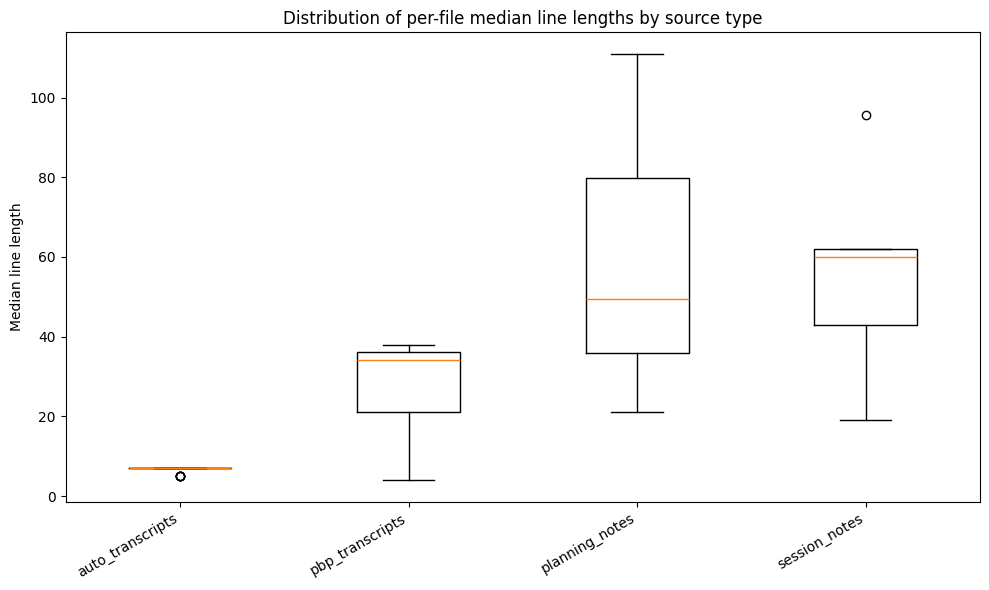

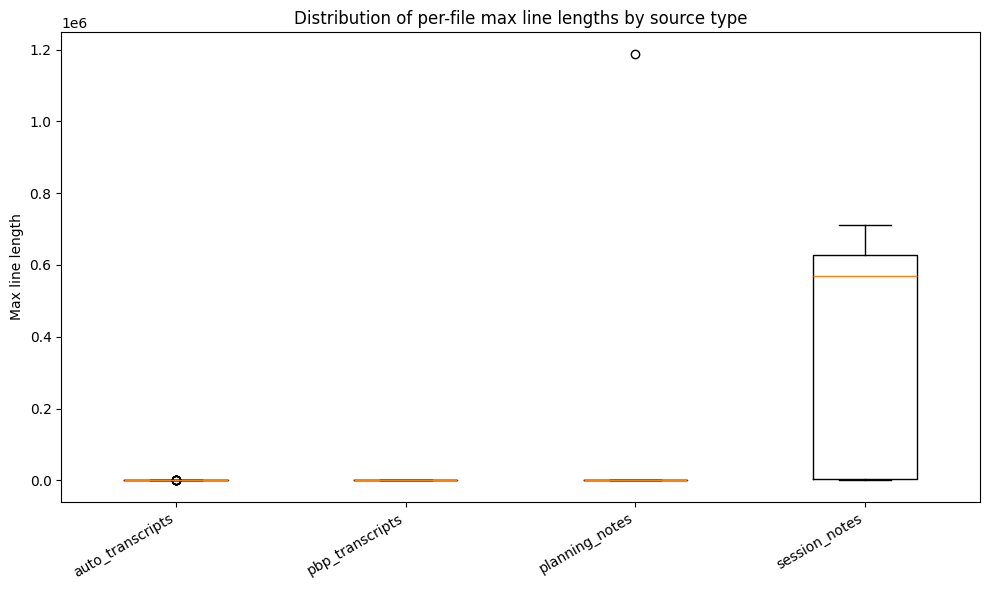

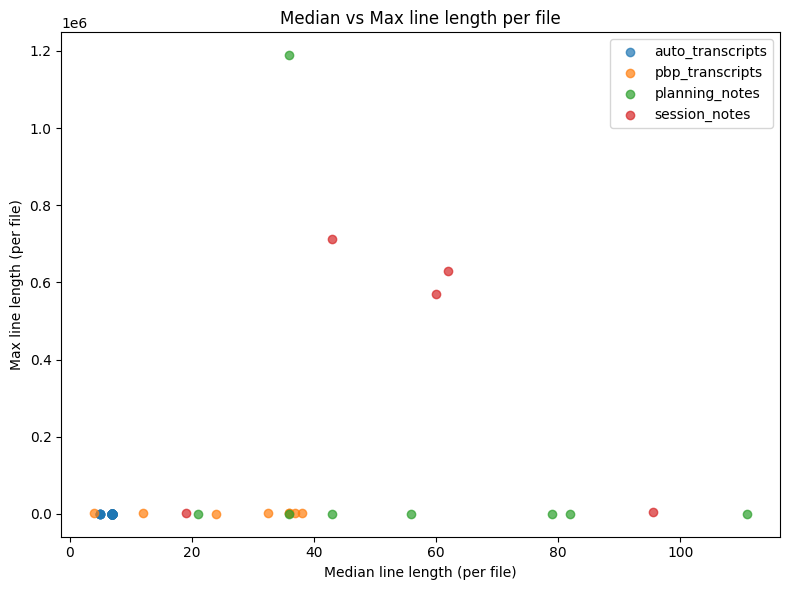

In [7]:
# Phase 4a: File-level line length profiling and charts
# Observational only — no persistence, no mutation

from collections import defaultdict
from statistics import mean, median
import matplotlib.pyplot as plt
import numpy as np

if not LOADED_SOURCES:
    raise ValueError("No loaded sources found. Run Phase 3 first.")

# --- collect per-file 5-number summaries ---
file_profiles = []

for src in LOADED_SOURCES:
    lengths = sorted(len(l) for l in src["lines"] if l)

    if not lengths:
        continue

    q1 = np.percentile(lengths, 25)
    q3 = np.percentile(lengths, 75)

    file_profiles.append({
        "source_type": src["source_type"],
        "min": lengths[0],
        "q1": q1,
        "median": median(lengths),
        "q3": q3,
        "max": lengths[-1],
    })

# --- group by source_type ---
by_type = defaultdict(list)
for p in file_profiles:
    by_type[p["source_type"]].append(p)

# --- Box plots: distribution of medians by source type ---
plt.figure(figsize=(10, 6))

labels = []
data = []

for source_type in sorted(by_type.keys()):
    labels.append(source_type)
    data.append([p["median"] for p in by_type[source_type]])

plt.boxplot(data, tick_labels=labels, showfliers=True)
plt.title("Distribution of per-file median line lengths by source type")
plt.ylabel("Median line length")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Box plots: distribution of max line lengths by source type ---
plt.figure(figsize=(10, 6))

labels = []
data = []

for source_type in sorted(by_type.keys()):
    labels.append(source_type)
    data.append([p["max"] for p in by_type[source_type]])

plt.boxplot(data, tick_labels=labels, showfliers=True)
plt.title("Distribution of per-file max line lengths by source type")
plt.ylabel("Max line length")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Scatter: median vs max (outlier detector) ---
plt.figure(figsize=(8, 6))

for source_type in sorted(by_type.keys()):
    medians = [p["median"] for p in by_type[source_type]]
    maxes = [p["max"] for p in by_type[source_type]]
    plt.scatter(medians, maxes, label=source_type, alpha=0.7)

plt.xlabel("Median line length (per file)")
plt.ylabel("Max line length (per file)")
plt.title("Median vs Max line length per file")
plt.legend()
plt.tight_layout()
plt.show()

# cleanup
del src, lengths, q1, q3, p
del labels, data, medians, maxes
del file_profiles, by_type, source_type

In [8]:
# Phase 4b: Sanity check: preview a loaded source by ID

PREVIEW_SOURCE_ID = 120
PREVIEW_MAX_LINES = 50

s = next((x for x in LOADED_SOURCES if x["source_id"] == PREVIEW_SOURCE_ID), None)
if s is None:
    available = sorted(x["source_id"] for x in LOADED_SOURCES)
    raise ValueError(
        f"No loaded source found with source_id={PREVIEW_SOURCE_ID}. "
        f"Available source_id values: {available}"
    )

# display path relative to WORLD_ROOT if possible
try:
    show_path = s["path"].relative_to(WORLD_ROOT)
except Exception:
    show_path = s["path"]

print(f"[{s['source_id']}] {s['file_type']}: {show_path}  [{s['source_type']}]")
print("")

for i, line in enumerate(s["lines"][:PREVIEW_MAX_LINES], start=1):
    print(f"{i:>4}: {line}")

# clean up local variables
del i, line, s, show_path
del PREVIEW_SOURCE_ID, PREVIEW_MAX_LINES


[120] md: _local/planning_notes/The Wolfstream Situation.md  [planning_notes]

   1: ## 25 Fons 703 \- From Abbey to King’s Marshal
   2: 
   3: 25 Fons 703
   4: 
   5: Alister Cullen  
   6: King's Marshal  
   7: Dornham Keep
   8: 
   9: Commander Cullen,
  10: 
  11: We are getting reports of remote camps being overrun by large, ugly beings. The description doesn't match that of any people I know of, but they are aggressive and deadly. We are expecting refugees from remote settlements.
  12: 
  13: Although Wolfstream Abbey is the administrative center, we do not maintain any sort of fighting force beyond a few hunters. I request you send some reinforcements to bring this situation under control.
  14: 
  15: With respect,
  16: 
  17: Mother Brigitte Ware  
  18: Abbess  
  19: Wolfstream Abbey
  20: 
  21: \-------------------------
  22: 
  23: ## 29 Fons 703 \- From King’s Marshal to Abbey
  24: 
  25: 29 Fons 703
  26: 
  27: Mother Brigitte Ware  
  28: Abbess  
  29: Wolfst

In [9]:
# Phase 4c: deciling line lengths for a specific source type

import numpy as np
import pandas as pd

rows = []

for src in LOADED_SOURCES:
    if src["source_type"] != "session_notes":
        continue

    path = src["path"]
    lines = src["lines"]

    if not lines:
        continue

    # Extract last 3 characters before ".txt"
    stem = path.stem
    file_id = stem[-3:]

    line_lengths = [len(line) for line in lines]
    deciles = np.percentile(line_lengths, range(0, 101, 10))

    row = {"file": file_id}
    for p, value in zip(range(0, 101, 10), deciles):
        row[f"p{p}"] = value

    rows.append(row)

df_auto_deciles = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
df_auto_deciles

# clean up local variables
del rows, src, path, lines, stem, file_id, line_lengths
del deciles, row, p, value, df_auto_deciles

In [10]:
# Phase 4d: Scan session_notes for "session" header signal
import re

SESSION_WORD_REGEX = re.compile(r"\bsession\b", re.IGNORECASE)

total_hits = 0
files_with_hits = 0

print('Scanning session_notes for word "session"...\n')

for src in LOADED_SOURCES:
    if src.get("source_type") != "session_notes":
        continue

    path = src["path"]
    lines = src["lines"]

    file_hits = 0

    for idx, line in enumerate(lines, start=1):
        if SESSION_WORD_REGEX.search(line):
            if file_hits == 0:
                files_with_hits += 1
                print(f"\nFILE: {path.name}")
            file_hits += 1
            total_hits += 1
            print(f"  L{idx}: {line}")

    if file_hits:
        print(f"  -> hits in file: {file_hits}")

print("\nSummary:")
print(f"Files scanned: {sum(1 for s in LOADED_SOURCES if s.get('source_type') == 'session_notes')}")
print(f"Files with hits: {files_with_hits}")
print(f"Total 'session' hits: {total_hits}")

# cleanup
del SESSION_WORD_REGEX, total_hits, files_with_hits, src, path, lines, idx, line, file_hits

Scanning session_notes for word "session"...


FILE: current_IWTC session notes.md
  L1: ## Session 151 Jotunheim outpost \- 2025-06-01
  L15: ## Session 152 Jotunheim outpost \- 2025-06-08
  L62: ## Session 153 Jotunheim wilderness \- 2025-06-15
  L97: ## Session 154 Jotunheim wilderness \- 2025-07-20
  L143: ## Session 155 Jotunheim wilderness \- 2025-08-03
  L161: ## Session 156 Crafthold \- 2025-08-10
  L176: ## Session 157 Crafthold \- 2025-08-24
  L192: ## Session 158 Crafthold \- 2025-09-21 \- Birthday Party
  L206: ## Session 159 Crafthold \- 2025-10-05
  L264: ## Session 160 K3 \- 2025-10-19
  L297: ## Session 161 K2A \- 2025-11-09
  L312: ## Session 162 K2A/B \- 2025-11-23
  L360: ## Session 163 K2B \- 2025-12-14
  L370: ## Session 164 K2B \- 2025-12-21
  -> hits in file: 14

FILE: IWTC session notes 1-50.md
  L9: ## Session 1: Traveling forge \- 2020-01-18 Sat
  L25: ## Session 1.5: Pip's day \- 2020-01-27 Mon
  L35: ## Session 2: Sat 2020-02-01 \- Deciding what to do with B

### Phase 4: Data Profiling & Structural Findings

This phase focused on **observing and understanding the real structure of raw source data** before proposing any chunking or indexing rules.

No transformation, normalization, or chunking was performed in this phase.  
All conclusions are based on direct inspection of normalized line-level data produced in Phase 3.

The purpose of Phase 4 is to ensure that any future chunking rules are grounded in **how the data is actually written**, not assumptions.

---

### What Was Analyzed

All available source files were loaded and profiled:

- OVERRIDE_PATHS = None
- SOURCE_MODE = "ALL"
- Total files analyzed: **125**
- Formats included:
  - `.txt`
  - `.md`
  - `.docx`

For each file, line-length distributions were analyzed using:
- minimum
- deciles / quantiles
- median
- maximum
- standard deviation

Analysis was grouped by **source_type**, not file format.

---

### Key Findings by Source Type

#### 1. auto_transcripts

**Observed structure**
- Files follow a rigid, repeating pattern:
  - One blank line
  - Timestamp line
  - One line of spoken text
- Approximately 50% timestamps, 50% dialogue
- Dialogue lines consistently range ~35–175 characters
- Extremely low variance across files

**Implications**
- This source is highly regular and predictable
- Structural units are already implicit in the data
- Line-level alternation is meaningful and should be preserved

---

#### 2. pbp_transcripts

**Observed structure**
- High structural variability
- Lines include:
  - speaker names
  - dialogue
  - emotes
  - blank lines
  - single-character markers (e.g., "-")
- Markdown formatting appears in some files but not others
- Datetimestamps are inconsistent and not always reliable
- Line-length distributions show a long tail:
  - Many very short lines
  - Occasional very long narrative blocks

**Implications**
- Speaker attribution matters
- Sequence matters more than timestamps
- Chunking must tolerate mixed formatting
- Line length alone is not a reliable delimiter

---

#### 3. planning_notes (docx-heavy)

**Observed structure**
- Formatting information from `.docx` is not preserved
- Blank lines consistently separate conceptual blocks
- Many blocks consist of a **single line**, often serving as:
  - section headers
  - category labels
- Lines are generally short; content is list-like
- Long lines are rare but present

**Implications**
- Blank lines are the primary structural signal
- Single-line blocks likely represent major sections
- The first line of a block often labels the block
- Formatting inference must be conservative

---

#### 4. session_notes

**Observed structure**
- Files often contain multiple sessions
- Session headers:
  - usually include a session number and a date
  - punctuation and exact format vary
- Blank lines separate complete thoughts
- Line-length distribution:
  - heavy use of blank lines
  - short median lines
  - very long tail (summaries, pasted narrative)
- One file is expected to produce many logical documents

**Implications**
- Document-level segmentation is required
- Blank lines represent paragraph boundaries
- Chunking must occur *within* session boundaries
- Over-splitting is safer than under-splitting

---

### Cross-Cutting Observations

- Blank lines are a **strong structural signal** across all human-authored sources
- Line length alone is insufficient for chunking decisions
- File format does not reliably indicate structure
- Source type is the most important determinant of chunking behavior
- Preserving original order and spacing is critical

---

### Resulting v0 Structural Contracts (Conceptual)

These are **conceptual contracts**, not implementations.

| Source Type        | Document Boundary        | Atomic Unit        |
|--------------------|--------------------------|--------------------|
| auto_transcripts   | File                     | Timestamp + text pair |
| pbp_transcripts    | File                     | Speaker / dialogue block |
| planning_notes     | File                     | Blank-line-delimited block |
| session_notes      | Session header            | Blank-line-delimited paragraph |

These contracts will guide future chunking design but are not yet codified.

## Phase 5: Chunking (v0)

In this phase, the notebook defines and applies **v0 chunking rules** to the normalized sources produced in Phase 3.

Chunking is the first structural transformation step: it groups contiguous lines into **chunks** that will later be indexed.

v0 is intentionally simple:

- A **new chunk begins** whenever a line matches any known *header pattern*
- All following lines belong to that chunk until the next header line
- Chunk boundaries preserve original line order and line numbers
- Chunking is designed for iterative refinement; anomalies are expected and will usually be handled by fixing the source file and rerunning

This phase produces:

- `CHUNKS_V0`: a list of chunk dictionaries suitable for later indexing steps

This phase performs **no semantic interpretation** and does not modify any source files on disk.

In [11]:
# Phase 5: Chunking v0 - consolidated header-driven chunking
# Input:  LOADED_SOURCES (list[dict])
# Output: CHUNKS_V0 (list[dict])

import re

TIME_LIKE_REGEX = r"\d{1,2}:\d{2}(?::\d{2})?(?:\s*[AP]M)?"

# Header regexes are evaluated in order; first match wins.
# Ordering reflects specificity and expected frequency.
HEADER_REGEXES = [
    # auto_transcripts (most frequent, most rigid)
    ("auto_ts", re.compile(r"^\s*\d{1,2}:\d{2}(?::\d{2})?\s*$")),

    # pbp_transcripts (Discord-style headers, sometimes numbered like "2. ### ...")
    ("pbp_hash", re.compile(rf"^\s*(?:\d+\.\s*)?(?:[*-]\s*)?###\s+.*{TIME_LIKE_REGEX}.*$")),

    # pbp_transcripts (forum-style quoted bold header)
    ("pbp_forum", re.compile(rf"^\s*>?\s*\*\*.*{TIME_LIKE_REGEX}.*\*\*\s*$")),

    # session_notes (lines beginning with optional format codes and "Session", omitting "Session notes")
    ("session", re.compile(r"^\s*(?:\d+\.\s*)?(?:[>#*_\-\s]+)?session\s+(?!notes\b)\S.*$",re.IGNORECASE,)),

    # planning_notes (lines beginning with markdown headers)
    ("md_heading",re.compile(r"^\s*(?:[*\-]\s*)?#{1,6}\s+\S.*$")),

]

CHUNKS_V0 = []
chunk_global_id = 1 # global (not per-file) to allow stable cross-file references

for src in LOADED_SOURCES:
    source_id = src["source_id"]
    path = src["path"]
    source_type = src.get("source_type", "unknown")
    file_type = src.get("file_type", "unknown")
    lines = src["lines"]

    current_kind = "preamble"
    current_lines = []
    chunk_start_line = 1

    for idx, line in enumerate(lines, start=1):
        matched_kind = next(
            (kind for kind, header_regex in HEADER_REGEXES if header_regex.match(line)),
            None,
        )

        if matched_kind:
            # Flush what we have so far (literal fidelity: keep preamble content too)
            if current_lines:
                CHUNKS_V0.append(
                    {
                        "chunk_id": chunk_global_id,
                        "source_id": source_id,
                        "source_type": source_type,
                        "file_type": file_type,
                        "path": path,
                        "start_line": chunk_start_line,
                        "end_line": idx - 1,
                        "header_kind": current_kind,  # None for preamble
                        "lines": list(current_lines),
                    }
                )
                chunk_global_id += 1

            # Start a new chunk at this header line (header is included)
            current_kind = matched_kind
            current_lines = [line]
            chunk_start_line = idx

        else:
            current_lines.append(line)

    # Flush final chunk (including files with no headers)
    if current_lines:
        CHUNKS_V0.append(
            {
                "chunk_id": chunk_global_id,
                "source_id": source_id,
                "source_type": source_type,
                "file_type": file_type,
                "path": path,
                "start_line": chunk_start_line,
                "end_line": len(lines),
                "header_kind": current_kind,
                "lines": list(current_lines),
            }
        )
        chunk_global_id += 1

print(f"Chunked v0: {len(CHUNKS_V0)} chunks from {len(LOADED_SOURCES)} files.")

# Cleanup locals (keep CHUNKS_V0)
del TIME_LIKE_REGEX, HEADER_REGEXES, chunk_global_id
del src, source_id, path, source_type, file_type, lines
del current_kind, current_lines, chunk_start_line, idx, line, matched_kind

# --- keep parameters ---
# Core working sets: CHUNKS_V0, LOADED_SOURCES
# Run intent: SOURCE_ORIGIN
# Repository anchors: WORLD_ROOT, WORLD_REPOSITORY_DESCRIPTOR
# I/O targets: WORKING_DRAFTS_PATH
# Phase 7 prerequisites: VOCAB_ENTITIES_PATH, VOCAB_ALIASES_PATH, VOCAB_PC_MAP_PATH

Chunked v0: 170010 chunks from 126 files.


## Phase 6: Vocabulary bootstrap (candidate proper nouns)

In this phase, the notebook generates a first-pass list of candidate proper nouns and named entities from the v0 chunks.

Goal:
- Produce a ranked candidate list of names/phrases worth adding to the world vocabulary.
- Provide evidence snippets so a human can confirm canon spellings and create aliases.

Approach (v0):
- Exclude `auto_transcripts` to avoid overwhelming the candidate list with conversational noise.
- Extract:
  - Multiword Title Case phrases (e.g., "Temple of the Bronze Flame")
  - Single-word Proper Nouns (e.g., "Dhassa", "Killeth")
- Aggregate counts by:
  - total mentions
  - chunks mentioned
  - files mentioned
  - source_type distribution
- Capture a small number of evidence snippets per candidate.

This phase does not resolve ambiguity (e.g., "temple" vs "monastery", or "Lia" vs "Liavarah").
It produces the evidence needed to curate aliases and canonical forms in a later step.


In [14]:
# Phase 6: Vocabulary bootstrap (candidate proper nouns)
# Input:  CHUNKS_V0 (list[dict])
# Output: CANDIDATE_VOCAB (pandas DataFrame) + CSV written to WORKING_DRAFTS_PATH
# Notes:
#  - Excludes auto_transcripts
#  - Output is intentionally noisy and non-canonical.
#  - All candidates require human review before inclusion in vocab registries.

import re
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
from datetime import datetime

# -----------------------
# Configuration (v0)
# -----------------------
EXCLUDE_SOURCE_TYPES = {"auto_transcripts"}

RUN_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

CONNECTORS = {
    "of", "the", "and", "to", "in", "at", "on", "for", "from", "with", "by", "a", "an",
}

# STOP_SINGLE is intentionally aggressive to suppress sentence-initial noise.
# Better to miss weak candidates than flood the review set.
STOP_SINGLE = {
    "I", "A", "An", "The", "And", "Or", "But", "We", "You", "He", "She", "They",
    "This", "That", "These", "Those", "It", "Its", "Our", "My", "Your", "His", "Her",
    "Session", "Sessions",
    # common sentence starters / function words that get capitalized at line start
    "No","Yes","What","Why","How","When","Where","Who","Whom","Which",
    "As","If","At","In","On","Not","With","Without","Within","For","From","To","Of",
    "And","Or","But","So","Then","Than","Now","Just","Only","Also","Still","Even",
    "There","Here","This","That","These","Those","It","Its","We","You","He","She","They",
    "Do","Does","Did","Can","Could","Will","Would","Shall","Should","May","Might","Must",
    "All","One","Well","Go","Ah","After","Oh","Let","AM","PM"
}

STOP_TOKENS = {"##", "#", "###", ">", "*", "-", "_", "`"}

MAX_EVIDENCE_PER_CANDIDATE = 5
MAX_SNIPPET_CHARS = 160

# -----------------------
# Regexes (v0)
# -----------------------
WORD_REGEX = re.compile(r"[A-Za-z][A-Za-z0-9'\-]*")
TITLE_WORD_REGEX = re.compile(r"^[A-Z][a-z][A-Za-z'\-]*$")
ACRONYM_REGEX = re.compile(r"^[A-Z]{2,8}$")

# -----------------------
# Aggregate structures
# -----------------------
mentions = Counter()                    # candidate -> total mentions
chunks_mentioned = defaultdict(set)     # candidate -> set(chunk_id)
files_mentioned = defaultdict(set)      # candidate -> set(path)
by_source_type = defaultdict(Counter)   # candidate -> Counter(source_type)
evidence = defaultdict(list)            # candidate -> list[evidence dict]

# -----------------------
# Main scan (exclude auto_transcripts)
# -----------------------
included_chunks = [
    c for c in CHUNKS_V0 if c.get("source_type") not in EXCLUDE_SOURCE_TYPES
]

for chunk in included_chunks:
    chunk_id = chunk["chunk_id"]
    source_type = chunk.get("source_type", "unknown")
    path = str(chunk.get("path", ""))
    lines = chunk.get("lines", [])
    header_kind = chunk.get("header_kind")
    
    # Drop pbp header line (metadata, not narrative)
    if (
        header_kind in {"pbp_hash", "pbp_forum","session"}
        and lines
    ):
        content_lines = lines[1:]
    else:
        content_lines = lines
    
    # Collapse all chunk text to single-space whitespace
    concat_text = " ".join(" ".join(content_lines).split())

    # Evidence snippet (reuse for all candidates found in this chunk)
    # This favors coverage over per-mention precision (acceptable for v0).

    if len(concat_text) > MAX_SNIPPET_CHARS:
        snippet = concat_text[: MAX_SNIPPET_CHARS - 3] + "..."
    else:
        snippet = concat_text

    # Tokenize for candidate extraction
    words = WORD_REGEX.findall(concat_text)
    candidates = []

    # ---- extract Title Case phrases ----
    i = 0
    n = len(words)

    while i < n:
        w = words[i]
        if TITLE_WORD_REGEX.match(w) or ACRONYM_REGEX.match(w):
            parts = [w]
            cap_count = 1
            j = i + 1

            while j < n:
                wj = words[j]
                wj_lower = wj.lower()

                if TITLE_WORD_REGEX.match(wj) or ACRONYM_REGEX.match(wj):
                    parts.append(wj)
                    cap_count += 1
                    j += 1
                elif wj_lower in CONNECTORS:
                    parts.append(wj_lower)
                    j += 1
                else:
                    break

            if cap_count >= 2:
                candidates.append(" ".join(parts))

            i = j
        else:
            i += 1

    # # Words that appear somewhere other than position 0
    # non_initial_words = set(words[1:])

    # ---- extract single-word propers ----
    for w in words:
        if (
            (TITLE_WORD_REGEX.match(w) or ACRONYM_REGEX.match(w))
            and w not in STOP_TOKENS
            and w not in STOP_SINGLE
            and (w != words[0] or w in words[1:])
        ):
            candidates.append(w)

    if candidates:
        seen_this_chunk = set()
    
        # Count mentions (raw frequency)
        for cand in candidates:
            mentions[cand] += 1
            seen_this_chunk.add(cand)
    
        # Per-chunk / per-file coverage + by_source_type
        for cand in seen_this_chunk:
            chunks_mentioned[cand].add(chunk_id)
            files_mentioned[cand].add(path)
            by_source_type[cand][source_type] += 1
    
            # Evidence snippets (cap count per candidate)
            if len(evidence[cand]) < MAX_EVIDENCE_PER_CANDIDATE:
                evidence[cand].append(
                    {
                        "chunk_id": chunk_id,
                        "source_type": source_type,
                        "path": path,
                        "start_line": chunk.get("start_line"),
                        "end_line": chunk.get("end_line"),
                        "snippet": snippet,
                    }
                )

# -----------------------
# Build DataFrame
# -----------------------
rows = []
for cand, total in mentions.most_common():
    rows.append(
        {
            "candidate": cand,
            "mentions_total": total,
            "chunks_mentioned": len(chunks_mentioned[cand]),
            "files_mentioned": len(files_mentioned[cand]),
            "source_types": dict(by_source_type[cand]),
        }
    )

CANDIDATE_VOCAB = pd.DataFrame(rows)

if not CANDIDATE_VOCAB.empty:
    CANDIDATE_VOCAB = (
        CANDIDATE_VOCAB
        .sort_values(
            by=["files_mentioned", "chunks_mentioned", "mentions_total"],
            ascending=[False, False, False],
        )
        .reset_index(drop=True)
    )

print(f"Excluded source types: {sorted(EXCLUDE_SOURCE_TYPES)}")
print(f"Chunks scanned: {len(included_chunks)}")
print(f"Candidates found: {len(CANDIDATE_VOCAB)}")
display(CANDIDATE_VOCAB.head(25))

# -----------------------
# Write outputs
# -----------------------
out_dir = Path(WORKING_DRAFTS_PATH)
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / f"candidate_vocab_v0_excluding_auto_transcripts_{RUN_STAMP}.csv"
CANDIDATE_VOCAB.to_csv(csv_path, index=False, encoding="utf-8")
print(f"Wrote: {csv_path}")

TOP_N = 150
md_path = out_dir / f"candidate_vocab_v0_evidence_top{TOP_N}_{RUN_STAMP}.md"

with md_path.open("w", encoding="utf-8") as f:
    f.write("# Candidate vocab evidence (v0, excluding auto_transcripts)\n\n")
    f.write("For human review. Ranked by file/chunk coverage.\n\n")

    for i, row in CANDIDATE_VOCAB.head(TOP_N).iterrows():
        cand = row["candidate"]
        f.write(f"## {i+1}. {cand}\n\n")
        f.write(f"- mentions_total: {row['mentions_total']}\n")
        f.write(f"- chunks_mentioned: {row['chunks_mentioned']}\n")
        f.write(f"- files_mentioned: {row['files_mentioned']}\n")
        f.write(f"- source_types: {row['source_types']}\n\n")

        for ev in evidence.get(cand, []):
            f.write(
                f"- chunk {ev['chunk_id']} [{ev['source_type']}] "
                f"{ev['path']} L{ev['start_line']}-L{ev['end_line']}\n"
            )
            f.write(f"  - {ev['snippet']}\n")

        f.write("\n")

print(f"Wrote: {md_path}")

# Cleanup locals (keep CANDIDATE_VOCAB for downstream use)
del RUN_STAMP, out_dir, csv_path, md_path, TOP_N
del included_chunks, chunk, chunk_id, source_type, path, lines, header_kind, content_lines
del concat_text, snippet, words, candidates, i, n, w, parts, cap_count, j, wj, wj_lower
del seen_this_chunk, cand, total, rows, row, ev, f
del mentions, chunks_mentioned, files_mentioned, by_source_type, evidence
del CONNECTORS, STOP_SINGLE, STOP_TOKENS
del MAX_EVIDENCE_PER_CANDIDATE, MAX_SNIPPET_CHARS
del WORD_REGEX, TITLE_WORD_REGEX, ACRONYM_REGEX
del EXCLUDE_SOURCE_TYPES

Excluded source types: ['auto_transcripts']
Chunks scanned: 1365
Candidates found: 16472


,candidate,mentions_total,chunks_mentioned,files_mentioned,source_types
0,Faeryne,817,219,18,"{'pbp_transcripts': 73, 'planning_notes': 9, '..."
1,Henry,782,263,17,"{'pbp_transcripts': 134, 'planning_notes': 14,..."
2,Alivyre,503,219,17,"{'pbp_transcripts': 99, 'planning_notes': 9, '..."
3,Lia,383,153,17,"{'pbp_transcripts': 71, 'planning_notes': 6, '..."
4,Crafthold,334,140,16,"{'pbp_transcripts': 30, 'planning_notes': 9, '..."
5,Victor,655,301,15,"{'pbp_transcripts': 248, 'planning_notes': 11,..."
6,Luminia,274,124,13,"{'pbp_transcripts': 40, 'planning_notes': 2, '..."
7,Urgulk,160,49,13,"{'pbp_transcripts': 20, 'planning_notes': 3, '..."
8,Elysia,68,52,12,"{'pbp_transcripts': 43, 'planning_notes': 5, '..."
9,Dhassa,75,29,12,"{'pbp_transcripts': 5, 'planning_notes': 5, 's..."


Wrote: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/machine_wip/candidate_vocab_v0_excluding_auto_transcripts_20260116_142259.csv
Wrote: /Users/charissophia/obsidian/Iron Wolf Trading Company/_local/machine_wip/candidate_vocab_v0_evidence_top150_20260116_142259.md


In [15]:
# Show top multi-word candidates by mentions
mw = CANDIDATE_VOCAB[CANDIDATE_VOCAB["candidate"].str.contains(" ", regex=False)]
display(mw.sort_values("mentions_total", ascending=False).head(10))
del mw

,candidate,mentions_total,chunks_mentioned,files_mentioned,source_types
41,Little Bear,22,18,8,"{'pbp_transcripts': 11, 'session_notes': 7}"
2367,PM Kavar,14,12,1,{'session_notes': 12}
152,Faeryne Faeryne,10,8,5,"{'pbp_transcripts': 1, 'session_notes': 7}"
161,Crafthold He,9,7,5,"{'pbp_transcripts': 2, 'session_notes': 5}"
438,PM He,9,8,3,"{'pbp_transcripts': 3, 'session_notes': 5}"
249,The Tolanites,8,7,4,"{'pbp_transcripts': 6, 'planning_notes': 1}"
463,Victor and Faeryne,8,6,3,"{'pbp_transcripts': 3, 'session_notes': 3}"
164,Bysickle Henry,7,7,5,{'pbp_transcripts': 7}
1043,Henry and Shworn,7,6,2,"{'planning_notes': 1, 'session_notes': 5}"
1035,The Folly,7,7,2,{'session_notes': 7}


## Phase 7: Entity linking

In this phase, the notebook applies the curated vocabulary to the chunked source data in order to identify where known entities appear across the corpus.

At this point, the source material has already been normalized and segmented into `CHUNKS_V0`. Each chunk represents a bounded region of text with stable source metadata and preserved line structure.

This phase introduces the first **interpretive pass** over the content, but does so conservatively. Only explicitly defined entities and aliases are considered, and no new vocabulary is inferred or generated.

In this phase, the notebook:
- Loads the authoritative entity registry and alias mappings
- Applies boundary-aware matching to chunk text
- Links canonical names and approved aliases to their occurrences
- Records each match with its source and positional context
- Produces a structured table of entity mentions

This phase performs the task:

**“Where do known entities appear in the corpus?”**

This phase does not attempt to resolve ambiguity, infer relationships, or interpret meaning. It does not introduce new entities, merge concepts, or collapse roles.

The output of this phase is a **reference index** of entity mentions, suitable for later aggregation, querying, and graph construction.